## K-delayed rectifier channel currents. 
### Prof. Marco Arieli Herrera-Valdez,
### National Autonomous University of Mexico. 

A voltage clamp experiment consists of recording currents from a cell in response to a clamp in the transmembrane potential to a set of volgate "commands". The currents have a time course with essentially two components, activation and inactivation, respectively, with different underlying biophysical mechanisms and temporal components. The main idea is that a channel is open only when it is both activated and _not_ inactivated. Some channels inactivate very slowly and are called "noninactivating". The activation and inactivation processes can sometimes be separated experimentally, which lead Hodgkin & Huxley (1952), and since then, others, to model the opening process as the product of two variables between 0 and 1, representing activation and inactivation, respectively. The activation and inactivation curves recorded experimentally  resemble logistic, or sometimes linear dynamics, depending on the case, with voltage-dependent steady states and rates. That is, for any given voltage
\begin{equation}
\partial_t w = r_w w^{\alpha} \frac{ \phi_{s}(v) - w }{\tau_w(v)}
\end{equation}
where $r$ and $f$ represent the time constant and steady state for $w$. The exponent $\alpha$ controls whether the dynamics are linear, logistic, or possibly other.

This tutorial focuses on building a model for non-inactivating $K^+$ and simulating what would be a voltage clamp experiments for a gating variable that could have either linear or logistic dynamics.

__References__

Hodgkin & Huxley, (1952) A quantitative description of membrane current and its application to conduction and excitation in nerve.  The Journal of physiology. 

Herrera-Valdez M.A. (2012) Membranes with the Same Ion Channel Populations but Different Excitabilities. PLoS ONE 7(4): e34636. doi:10.1371/journal.pone.0034636

Herrera-Valdez, M.A. et al. (2013) Relating ion channel expression, bifurcation structure, and diverse firing patterns in a model of an identified motor neuron. Journal of Computational Neuroscience, April 2013, Volume 34, Issue 2, pp 211-229.

Herrera-Valdez M.A. (2015). A unifying theory to describe transmembrane transport derived from thermodynamic principles. PeerJ PrePrints

Python tutorial. https://docs.python.org/2/tutorial/

Now let us build an example of voltage clamp simulation. First import the necessary modules.

In [31]:
import matplotlib.pyplot as gr
import scipy as sc
sc.test('integrate')

.

Running unit tests for scipy
NumPy version 1.8.0rc1
NumPy is installed in /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy
SciPy version 0.13.0b1
SciPy is installed in /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy
Python version 2.7.10 (v2.7.10:15c95b7d81dc, May 23 2015, 09:33:12) [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
nose version 1.3.7



----------------------------------------------------------------------
Ran 1 test in 2.272s

OK


<nose.result.TextTestResult run=1 errors=0 failures=0>

Notice the output of the testing command. This is a necessary step because some of the ode solving tools in scipy are not available until the tests have been performed. 

First make sure that you can see graphs on this sheet.

In [1]:
%matplotlib inline

The current we are about to simulate is mediated by _delayed-rectifier_ K$^+$ channels. A generic functional form for the current derived from thermodynamic and kinetic principles is given by (Herrera-Valdez, 2012, 2013, 2015)
\begin{equation}
I_K = \bar{a} w \left[ 
\exp \left( b_K z_K \frac{v-v_K}{v_T} \right) 
- 
\exp \left( (b_K-1) z_K \frac{v-v_K}{v_T} \right) 
\right]
\end{equation}
where $v$ represents the transmembrane potential and $w$ represents the proportion of open channels in the membrane. The parameters $v_K$ and $z_K$ represent the Nernst potential and valence for K$^+$. The parameter $b_K \in [0,1]$ represents a rectification bias for the current. Notice $b_K$ close to 0 or close to 1 yield inward or outward rectification, respectively. 

The delayed-rectifier K$^+$ current we want to model inactivates very slowly, which makes it possible to assume that opening is essentially activation. The voltage-dependence of the steady state and time constant for a variable like $w$ can be modelled by using functions like
\begin{eqnarray}
\phi(v) &=& \frac{ \exp \left( s_w \frac{v-v_w}{v_T} \right)}{1+\exp \left(s_w \frac{v-v_w}{v_T} \right)} 
\\
\tau^{-1}(v) &=& r_w\left[ \exp \left( b_w s_w \frac{v-v_w}{v_T} \right) + \exp \left((b_w-1) s_w \frac{v-v_w}{v_T} \right) \right] 
\end{eqnarray}
where $v_w$ and $g_w$ control the _half-activation potential_ and _slope_ for the steady state. The parameter $b_w$ controls the bias of the time constant. For instance, $b_w=1/2$, yields symmetric time constants centered around $v_w$. 

From the equations above, it is clear that the model of current depends on three generic functions of the form
\begin{eqnarray}
F(x) &=& \frac{e^x}{1+e^x}
\\
S(x,s) &=& e^{sx} - e^{(s-1)x}
\\
\\
C(x,s) &=& e^{sx} + e^{(s-1)x}
\end{eqnarray}

In [3]:
# Define some auxiliary functions 
def F(x):
    "Forward sigmoidal function"
    ee = sc.exp(x)
    return  ee/(1+ee)

def S(x,s=0.5): 
    "Difference of exponential functions. Note the default value for s gives a hyperbolic sine."
    return sc.exp(x*s) *(1 - sc.exp(-x))

def C(x,s=0.5): 
    "Sum of exponential functions. The default value for s gives a hyperbolic cosine."
    return sc.exp(x*s) * (1 + sc.exp(-x))


Let's graph the functions to see their shape. To do so, define first the variables we will need. 

In [18]:
# Transmembrane potential
v = sc.arange(-150,150,0.1)
# An array with three different values for s
s = sc.array([0.25,0.5,0.75])
# Dictionary with Nernst parameters 
p={'vT' : 27.0, 'vNa':60.0, 'vK':-90.0, 'vNaK':-60.0}
# Add parameters for the K-delayed rectifier
pKD={'wHA': -1.0, 'wGC': 3.0, 'wRate':2.0, 'wPow':1.0, 'wS': 0.3, 'aBarKD':1.0}  
p.update(pKD)
# Check the contents of the dictionary
for k,i in p.items():
    print(k,i)

('vNaK', -60.0)
('wPow', 1.0)
('wHA', -1.0)
('vNa', 60.0)
('aBarKD', 1.0)
('wRate', 2.0)
('vK', -90.0)
('vT', 27.0)
('wGC', 3.0)
('wS', 0.3)


Draw some graphs to see the shape of the functions we defined. Note one of the graphs is inverted. Also note the "for" loop to iterate over the values of s. 

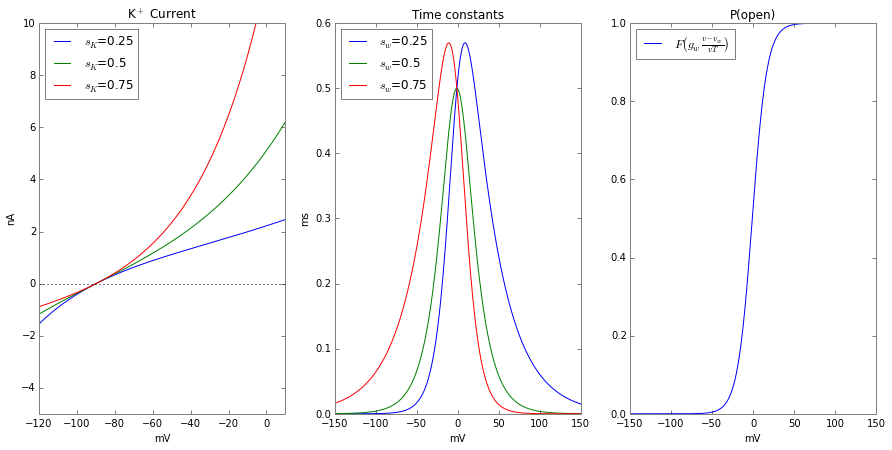

In [19]:
f1= gr.figure(figsize=(15,7))
r=1; c=3;  
ax1 = f1.add_subplot(r,c,1)  
ax2 = f1.add_subplot(r,c,2)  
ax3 = f1.add_subplot(r,c,3)  
# Interactive mode off 
gr.ioff()
# Draw a plot for each value of s
for ss in s: 
    # A formatted string for the label. The "r" before the string is for "raw" input (gets compiled as LaTeX code)
    str0=r"$s_{K}$=%g"%(ss,)
    str1=r"$s_{w}$=%g"%(ss,)
    y1= p['wGC']*(v-p['wHA'])/p['vT']
    ax1.plot(v, S((v-p['vK'])/p['vT'], ss), label=str0)
    ax2.plot(v, 1/C(y1, ss), label=str1)
    
ax1.plot([-150,150], [0,0], 'k:')
ax3.plot(v, F(y1), label=r'$F\left(g_w \frac{v-v_w}{vT} \right)$')
# Set labels and limits
ax1.set_title('K$^+$ Current')
ax1.set_ylabel('nA'); ax1.set_ylim(-5,10)
ax1.set_xlabel('mV'); ax1.set_xlim(-120,10); 
ax2.set_title('Time constants')
ax2.set_xlabel('mV'); ax2.set_ylabel('ms')
ax3.set_title('P(open)')
ax3.set_xlabel('mV');
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
gr.ioff(); gr.draw()      

Now let us simulate a voltage clamp experiment using two different formulations for the activation dynamics. Note the difference between the graphs. Why does that happen?

Define a differential equation that describes the dynamics for the activation variable w. Note that wPow=0 gives linear dynamics, and wPow=1 gives logistic dynamics.

In [20]:
def activation(w, t, pa):
    wSS, wRate,wPow=pa
    return wRate* (w**wPow) * (wSS-w)

Simulate a voltage clamp experiment solving the equation for w using different (command) voltage values

[0.99998505488483502, 11.21281753465983, 1.0]
[[ 0.  0.  0. ...,  0.  0.  0.]]
[0.99986210620798366, 5.7575603698921247, 1.0]
[[  5.000e-03   4.544e-03   4.164e-03 ...,   5.314e-05   5.313e-05   5.313e-05]]
[0.99872898373691865, 2.9593838645928585, 1.0]
[[ 0.01   0.01   0.009 ...,  0.     0.     0.   ]]
[0.98839268355469534, 1.5352877283710669, 1.0]
[[ 0.015  0.015  0.015 ...,  0.004  0.004  0.004]]
[0.90222740014920066, 0.86352245153830642, 1.0]
[[ 0.02   0.02   0.02  ...,  0.038  0.038  0.038]]
[0.5, 0.80000000000000004, 1.0]
[[ 0.025  0.025  0.026 ...,  0.269  0.269  0.269]]
[0.097772599850799322, 2.1004539914702689, 1.0]
[[ 0.03   0.031  0.032 ...,  0.772  0.772  0.772]]
[0.011607316445304629, 9.0838270622786919, 1.0]
[[ 0.035  0.037  0.039 ...,  0.969  0.969  0.969]]
[0.0012710162630813579, 42.591204272560873, 1.0]
[[ 0.04   0.044  0.049 ...,  0.997  0.997  0.997]]


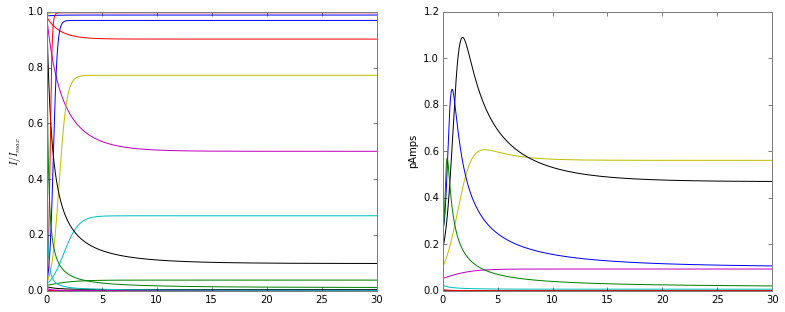

In [30]:
# Simulate voltage-clamp experiment
sampTimes= sc.arange(0,30,0.01)
vC= sc.arange(-110,70,20.0) 
I= list()
pAct= list()
pInact= list()
#
f2= gr.figure(figsize=(13,5))
axVC1=f2.add_subplot(121)
axVC2=f2.add_subplot(122)
gr.ioff()
p['wHI']=-10.0
p["wGC_Inact"]=-3.0
p['wRate_Inact']=p['wRate']/5.0
for n in sc.arange(len(vC)):
    yA = p["wGC"]*(vC[n] - p['wHA'])/p['vT']
    yInact = p["wGC_Inact"]*(vC[n] - p['wHI'])/p['vT']
    wRateAct = p['wRate']* C(yA,p['wS'])
    wRateInact = p['wRate_Inact']* C(yInact,p['wS'])
    wSSAct = F(yA)
    wSSInact = F(yInact)
    pAct=[wSSAct,wRateAct,p['wPow']]
    pInact=[wSSInact,wRateInact,p['wPow']]
    print(pInact)
    #print(wRateAct,wRateInact)
    oA= sc.integrate.odeint(func=activation, y0= n*0.005, t=sampTimes, args=(pAct,)).transpose()
    oI= sc.integrate.odeint(func=activation, y0= 1-n*0.005, t=sampTimes, args=(pInact,)).transpose()
    print(oA)
    pAct.append(oA[0]); 
    pInact.append(oI[0])
    I.append(oA[0]*oI[0]* S((vC[n]-p['vK'])/p['vT']))
    axVC1.plot(sampTimes,oA[0])
    axVC1.plot(sampTimes,oI[0])
    axVC2.plot(sampTimes,I[n])

axVC1.set_ylabel(r'$I/I_{max}$')
axVC2.set_ylabel(r'pAmps')
gr.ion(); gr.draw()

We can write the above procedure as a function, and then run it for different conditions: different values for the symmetry parameter in the time constant, and different dynamics for w (linear and logistic)

In [23]:
# Simulate voltage-clamp experiment
def activationVClamp(pa, vC= sc.arange(-110,70,20.0), sampTimes= sc.arange(0,30.0, 0.01)):
    I= sc.zeros((len(vC),len(sampTimes)),'float32')
    pAct= sc.zeros((len(vC),len(sampTimes)),'float32')
    for n in sc.arange(len(vC)):
        y = (vC[n] - pa['wHA'])/pa['vT']
        wRate = pa['wRate']* C(y,pa['wS'])
        wSS = F(y)
        orbit= sc.integrate.odeint(func=activation, y0= n*0.005, t=sampTimes, args=([wSS,wRate,pa['wPow']],))
        pAct[n,:]=orbit[:,0]
        I[n,:] = p['aBarKD'] * orbit[:,0]* S((vC[n]-pa['vK'])/pa['vT'])
    return pAct, I

Now simulate the dynamics of activation using linear and logistic equations [Herrera-Valdez, (2015)](https://peerj.com/preprints/1312.pdf)

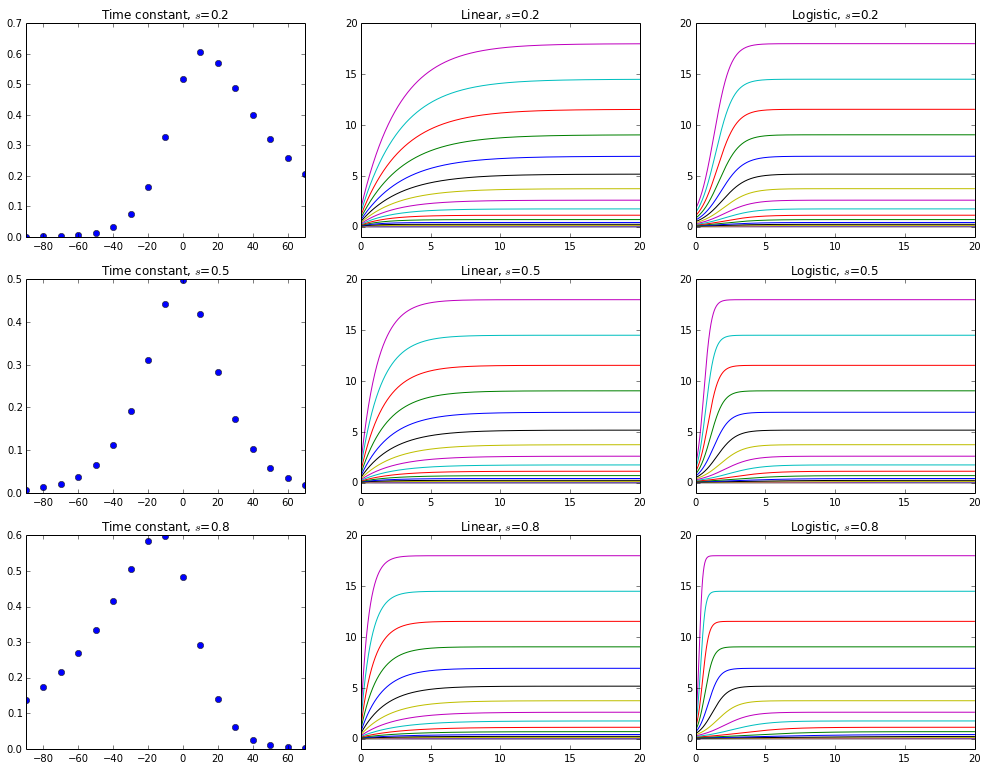

In [24]:
# Simulate voltage-clamps for different time constant symmetries and for linear and logistic dynamics

sTau= sc.array([0.2,0.5,0.8])
sampleTimes=sc.arange(0,20.0,0.01)
vCommands=sc.arange(-110,80,10.0)
rows=len(sTau); cols=3
f3= gr.figure(figsize=(17,13))
axVC=list()
gr.ioff()
for n in sc.arange(rows*(cols)):
    axVC.append(f3.add_subplot(rows, cols, n+1))


wLinear=list(); iLinear=list()
wLogistic=list(); iLogistic=list()
yw = p['wGC']*(vCommands - p['wHA'])/p['vT']
for m in sc.arange(len(sTau)):
    p['wS']= sTau[m]
    p['wPow']=0.0; p['wRate']=0.2;
    wVC0, iVC0= activationVClamp(pa=p, vC= vCommands, sampTimes= sampleTimes) 
    p['wPow']=1.0; p['wRate']=1.0
    wVC1, iVC1= activationVClamp(pa=p, vC= vCommands, sampTimes= sampleTimes) 
    for n in sc.arange(len(vCommands)):
        axVC[cols*m+1].plot(sampleTimes,iVC0[n,:])
        axVC[cols*m+2].plot(sampleTimes,iVC1[n,:])
    
    wRate=p['wRate'] * C(yw,p['wS'])
    axVC[cols*m].plot(vCommands,1/wRate,'o')
    axVC[cols*m+1].set_title(r'Linear, $s$=%g'%sTau[m])
    axVC[cols*m+2].set_title(r'Logistic, $s$=%g'%sTau[m])
    axVC[cols*m].set_title(r'Time constant, $s$=%g'%sTau[m])
    axVC[cols*m].set_xlim(-90,70)
    axVC[cols*m+1].set_ylim(-1,20)
    axVC[cols*m+2].set_ylim(-1,20)
    
gr.ion(); gr.draw()    